# Zajęcie 4: Nieliniowe sieci RNN w oparciu o tensory 
https://peterroelants.github.io/posts/rnn-implementation-part02/
Celem jest opracowanie nioliniowej RNN dla której wyjścia są tensory

In [54]:
# Imports
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import itertools
import numpy as np  # Matrix and vector computation package
import matplotlib
import matplotlib.pyplot as plt  # Plotting library
import seaborn as sns  # Fancier plots

# Set seaborn plotting style
sns.set_style('darkgrid')
# Set the seed for reproducability
np.random.seed(seed=1)
#

## Zestaw danych dodawania binarnego przechowywany w tensorze
Tutaj używany zestaw danych składający się z 2000 próbek szkoleniowych do uczenia RNN, który można utworzyć za pomocą metody `create_dataset` zdefiniowanej poniżej. Każda próbka składa się z dwóch 6-bitowych liczb wejściowych $(x_{i1},x_{i2})$
,
  dopełnionych 0, aby miały długość 7 znaków, i 7-bitową liczbą docelową $t_i$ aby
  $t_i = x_{i1}+x_{i2}$ ($i$
  jest indeksem próbki). Liczby są reprezentowane jako liczby binarne z najbardziej znaczącym bitem po prawej stronie (najpierw mamy najmniej znaczący bit). Dzieje się tak, aby nasz RNN mógł wykonać  dodawanie od lewej do prawej.

Wektory wejściowe i docelowe są przechowywane w tensorze trzeciego rzędu. <b>Tensor</b> to uogólnienie wektorów i macierzy, wektor to tensor pierwszego rzędu, macierz to tensor drugiego rzędu. Rzędność tensora to wymiar struktury danych tablicowych potrzebnych do jego reprezentacji.
Wymiary naszych danych treningowych ( `X_train` , `T_train` ) są drukowane po utworzeniu poniższego zestawu danych. Pierwszy wymiar naszych tensorów danych obejmuje wszystkie próbki (2000 próbek), drugi wymiar obejmuje zmienne w jednostce czasu (7 przedziałów czasowych), a trzeci wymiar obejmuje zmienne dla każdego kroku czasowego i próbki (np. zmienne wejściowe $x_{ik1}$, $x_{ik2}$,
  z $i$ to indeks próbki i $k$ to 
  krok czasowy). Tensor wejściowy `X_train` jest przedstawiony na poniższym rysunku:
 
 <img src="https://peterroelants.github.io/images/RNN_implementation/SimpleRNN02_Tensor.png"/>

## Inicjalizacja zbioru danych treningowych

In [55]:
# Create dataset
nb_train = 2000  # Number of training samples
# Addition of 2 n-bit numbers can result in a n+1 bit number
sequence_len = 32  # Length of the binary sequence

def create_dataset(nb_samples, sequence_len):
    """Create a dataset for binary addition and 
    return as input, targets."""
    max_int = 2**(sequence_len-1) # Maximum integer that can be added
     # Transform integer in binary format
    format_str = '{:0' + str(sequence_len) + 'b}'
    nb_inputs = 2  # Add 2 binary numbers
    nb_outputs = 1  # Result is 1 binary number
    # Input samples
    X = np.zeros((nb_samples, sequence_len, nb_inputs))
    # Target samples
    T = np.zeros((nb_samples, sequence_len, nb_outputs))
    # Fill up the input and target matrix
    for i in range(nb_samples):
        # Generate random numbers to add
        nb1 = np.random.randint(0, max_int)
        nb2 = np.random.randint(0, nb1 - 1)
        
        # Fill current input and target row.
        # Note that binary numbers are added from right to left, 
        #  but our RNN reads from left to right, so reverse the sequence.
        X[i,:,0] = list(
            reversed([int(b) for b in format_str.format(nb1)]))
        X[i,:,1] = list(
            reversed([int(b) for b in format_str.format(nb2)]))
        T[i,:,0] = list(
            reversed([int(b) for b in format_str.format(nb1 - nb2)]))
    return X, T

# Create training samples
X_train, T_train = create_dataset(nb_train, sequence_len)
print(f'X_train tensor shape: {X_train.shape}')
print(f'T_train tensor shape: {T_train.shape}')
#

X_train tensor shape: (2000, 32, 2)
T_train tensor shape: (2000, 32, 1)


## Dodawanie binarne (przykład)
Wykonywanie dodawania binarnego jest interesującą zabawką, ilustrującą sposób, w jaki rekurencyjne sieci neuronowe przetwarzają strumienie wejściowe w strumienie wyjściowe. Sieć musi nauczyć się, jak przenieść bit do następnego stanu (pamięci) i kiedy wyprowadzić 0 lub 1 w zależności od wejścia i stanu.

Poniższy kod drukuje wizualizację danych wejściowych i docelowych danych wyjściowych, które ma generować nasza sieć.

In [56]:
# Show an example input and target
def printSample(x1, x2, t, y=None):
    """Print a sample in a more visual way."""
    x1 = ''.join([str(int(d)) for d in x1])
    x1_r = int(''.join(reversed(x1)), 2)
    x2 = ''.join([str(int(d)) for d in x2])
    x2_r = int(''.join(reversed(x2)), 2)
    t = ''.join([str(int(d[0])) for d in t])
    t_r = int(''.join(reversed(t)), 2)
    if not y is None:
        y = ''.join([str(int(d[0])) for d in y])
    print(f'x1:   {x1:s}   {x1_r:2d}')
    print(f'x2: - {x2:s}   {x2_r:2d}')
    print(f'      -------   --')
    print(f't:  = {t:s}   {t_r:2d}')
    if not y is None:
        print(f'y:  = {y:s}')
    
# Print the first sample
printSample(X_train[0,:,0], X_train[0,:,1], T_train[0,:,:])
#

x1:   10100100001011111000001101010110   1791095845
x2: - 00110001111101001110011000011100   946286476
      -------   --
t:  = 10011001001000110101101001001100   844809369


## Rekurencyjna architektura sieci neuronowej
Nasza rekurencyjna sieć weźmie 2 zmienne wejściowe dla każdej próbki dla każdego punktu czasowego, przekształci je w stany i wyprowadzi pojedyncze prawdopodobieństwo, że bieżące wyjście jest 1
  (zamiast 0). Wejście jest przekształcane w stany RNN, w których może przechowywać informacje, aby sieć wiedziała, co wypisać w następnym kroku czasowym.

Istnieje wiele sposobów wizualizacji RNN, które zamierzamy zbudować. Możemy zwizualizować sieć tak i rozwinąć przetwarzanie każdego wejścia, aktualizacji stanu i wyjścia pojedynczego kroku czasowego niezależnie od innych kroków czasowych.

<img src="https://peterroelants.github.io/images/RNN_implementation/SimpleRNN02_1.png"/>

Lub możemy zobaczyć przetwarzanie pełnego wejścia, aktualizacje stanu i pełne wyjście oddzielnie od siebie. Pełny tensor wejściowy można mapować równolegle, aby był używany bezpośrednio w aktualizacjach stanu RNN. A także stany RNN mogą być mapowane równolegle do wyjścia każdego kroku czasowego.

<img src="https://peterroelants.github.io/images/RNN_implementation/SimpleRNN02_2.png"/>

Kroki są wyabstrahowane w różnych klasach poniżej. Każda klasa ma metodę do przodu, która wykonuje kroki propagacji wstecznej do przodu, oraz metodę wsteczną, która wykonuje kroki wstecznej propagacji wstecznej.

## Przetwarzanie tensorów wejściowych i wyjściowych
### Transformacja liniowa
Sieci neuronowe zazwyczaj przekształcają wektory wejściowe przez mnożenie macierzy i dodawanie wektorów, po czym następuje nieliniowa funkcja aktywacji. Dwuwymiarowe wektory wejściowe do naszej sieci to $(x_{ik1},x_{ik2})$
  są przekształcane przez $2\times 3$-
  macierz wag i wektor odchylenia o rozmiarze 3. Zanim będą mogły zostać dodane do stanów RNN, trójwymiarowe wektory stanu są przekształcane w jednowymiarowy wektor wyjściowy przez $3\times 1$-
  macierz wag i wektor odchylenia o rozmiarze 1, aby uzyskać wyjściowe prawdopodobieństwa.

Ponieważ chcemy przetworzyć wszystkie dane wejściowe dla każdej próbki i każdego kroku czasowego w jednym obliczeniu, możemy użyć funkcji numpy `tensordot` do wykonania iloczynów skalarnych. Ta funkcja przyjmuje 2 tensory i osie, które należy zagregować przez zsumowanie elementów i iloczyn wyniku. Na przykład transformacja wejścia $X$ ($2000\times 7\times 2$) do stanów S ($2000\times 7\times 3$) za pomocą macierzy $W$ ($2\times 3$) można zrobić przez `S = tensordot(X, W, axes=((-1),(0)))` . Ta metoda zsumuje elementy ostatniego rzędu (-1) z $X$ z elementami pierwszego rzędu (0) z $W$ i pomnoży je razem. Jest to to samo, co robienie iloczynu skalarnego macierzy dla każdego wektora $[x_{ik1},x_{ik2}]$
przez $W$. `tensordot` może wtedy upewnić się, że podstawowe obliczenia mogą być wykonywane wydajnie i równolegle.

Te liniowe transformacje tensorowe służą do przekształcania wejścia $X$ w stany $S$ oraz ze stanów $S$ w wyjście $Y$. Ta transformacja liniowa wraz z jej gradientem jest zaimplementowana w klasie `TensorLinear` poniżej. Należy zauważyć, że wagi są inicjowane przez równomierne próbkowanie pomiędzy $\pm \sqrt{6.0/(n_{in}+n_{out})}$.

## Klasyfikacja logistyczna
Klasyfikacja logistyczna służy do wyprowadzenia prawdopodobieństwa, 
że wynik w bieżącym kroku czasowym $k$ wynosi 1. 
Ta funkcja wraz z jej stratą i gradientem jest zaimplementowana w klasie `LogisticClassifier` poniżej.

In [57]:
# Define the linear tensor transformation layer
class TensorLinear(object):
    """The linear tensor layer applies a linear tensor dot product 
    and a bias to its input."""
    def __init__(self, n_in, n_out, tensor_order, W=None, b=None):
        """Initialse the weight W and bias b parameters."""
        a = np.sqrt(6.0 / (n_in + n_out))
        self.W = (np.random.uniform(-a, a, (n_in, n_out)) 
                  if W is None else W)
        self.b = (np.zeros((n_out)) if b is None else b)
        # Axes summed over in backprop
        self.bpAxes = tuple(range(tensor_order-1))

    def forward(self, X):
        """Perform forward step transformation with the help 
        of a tensor product."""
        # Same as: Y[i,j,:] = np.dot(X[i,j,:], self.W) + self.b 
        #          (for i,j in X.shape[0:1])
        # Same as: Y = np.einsum('ijk,kl->ijl', X, self.W) + self.b
        return np.tensordot(X, self.W, axes=((-1),(0))) + self.b

    def backward(self, X, gY):
        """Return the gradient of the parmeters and the inputs of 
        this layer."""
        # Same as: gW = np.einsum('ijk,ijl->kl', X, gY)
        # Same as: gW += np.dot(X[:,j,:].T, gY[:,j,:]) 
        #          (for i,j in X.shape[0:1])
        gW = np.tensordot(X, gY, axes=(self.bpAxes, self.bpAxes))
        gB = np.sum(gY, axis=self.bpAxes)
        # Same as: gX = np.einsum('ijk,kl->ijl', gY, self.W.T)
        # Same as: gX[i,j,:] = np.dot(gY[i,j,:], self.W.T) 
        #          (for i,j in gY.shape[0:1])
        gX = np.tensordot(gY, self.W.T, axes=((-1),(0)))  
        return gX, gW, gB

In [64]:
# Define the logistic classifier layer
class LogisticClassifier(object):
    """The logistic layer applies the logistic function to its 
    inputs."""
   
    def forward(self, X):
        """Perform the forward step transformation."""
        return 1. / (1. + np.exp(-X))
    
    def backward(self, Y, T):
        """Return the gradient with respect to the loss function 
        at the inputs of this layer."""
        # Average by the number of samples and sequence length.
        return (Y - T) / (Y.shape[0] * Y.shape[1])
    
    def loss(self, Y, T):
        """Compute the loss at the output."""
        return -np.mean((T * np.log(Y)) - ((1-T) * np.log(1-Y)))

## Rozwijanie stanów rekurencyjnych
Stany rekurencyjne muszą być rozwijane w czasie. To rozwijanie podczas propagacji wstecznej w czasie jest wykonywane przez klasę `RecurrentStateUnfold`. Ta klasa zawiera wspólne parametry wagi i odchylenia używane do aktualizacji każdego stanu, a także stan początkowy, który jest również traktowany jako parametr i optymalizowany podczas wstecznej propagacji.

Metoda `forward` klasy `RecurrentStateUnfold` iteracyjnie aktualizuje stany w czasie i zwraca wynikowy tensor stanu. Metoda wsteczna propaguje gradienty na wyjściach każdego stanu wstecz w czasie. Pamiętajmy, że za każdym razem $k$
  gradient pochodzący z wyjścia $Y$ należy dodać do gradientu pochodzącego z poprzedniego stanu w czasie $k+1$.
Gradienty parametrów wagi i odchylenia są sumowane we wszystkich krokach czasowych, ponieważ są to wspólne parametry w każdej aktualizacji stanu. Ostateczny gradient stanu w czasie $k=0$
  służy do optymalizacji stanu początkowego $S_0$
  ponieważ gradient stanu początkowego wynosi $\partial \xi/\partial S_0$.


`RecurrentStateUnfold` korzysta z klasy `RecurrentStateUpdate`. Metoda `forward` tej klasy łączy przekształcone dane wejściowe i stan w czasie
 $k-1$ do stanu wyjściowego $k$.
Metoda wsteczna propaguje gradient wstecz w czasie dla jednego kroku czasowego i oblicza gradienty parametrów tego kroku czasowego. Nieliniowa funkcja aktywacji używana w `RecurrentStateUpdate` jest funkcją tangensa hiperbolicznego (`tanh`). Ta funkcja, podobnie jak funkcja logistyczna, jest funkcją sigmoidalną, która wychodzi z -1 do +1.
Wybrano funkcję `tanh`, ponieważ maksymalny gradient tej funkcji jest większy niż maksymalny gradient funkcji logistycznej, co sprawia, że zanikanie gradientów jest mniej prawdopodobne. Ta funkcja transferu `tanh` jest zaimplementowana w klasie `TanH`.

In [65]:
# Define tanh layer
class TanH(object):
    """TanH applies the tanh function to its inputs."""
    
    def forward(self, X):
        """Perform the forward step transformation."""
        return np.tanh(X) 
    
    def backward(self, Y, output_grad):
        """Return the gradient at the inputs of this layer."""
        gTanh = 1.0 - (Y**2)
        return (gTanh * output_grad)

In [66]:
# Define internal state update layer
class RecurrentStateUpdate(object):
    """Update a given state."""
    def __init__(self, nbStates, W, b):
        """Initialse the linear transformation and tanh transfer 
        function."""
        self.linear = TensorLinear(nbStates, nbStates, 2, W, b)
        self.tanh = TanH()

    def forward(self, Xk, Sk):
        """Return state k+1 from input and state k."""
        return self.tanh.forward(Xk + self.linear.forward(Sk))
    
    def backward(self, Sk0, Sk1, output_grad):
        """Return the gradient of the parmeters and the inputs of 
        this layer."""
        gZ = self.tanh.backward(Sk1, output_grad)
        gSk0, gW, gB = self.linear.backward(Sk0, gZ)
        return gZ, gSk0, gW, gB

In [67]:
# Define layer that unfolds the states over time
class RecurrentStateUnfold(object):
    """Unfold the recurrent states."""
    def __init__(self, nbStates, nbTimesteps):
        """Initialse the shared parameters, the inital state and 
        state update function."""
        a = np.sqrt(6. / (nbStates * 2))
        self.W = np.random.uniform(-a, a, (nbStates, nbStates))
        self.b = np.zeros((self.W.shape[0]))  # Shared bias
        self.S0 = np.zeros(nbStates)  # Initial state
        self.nbTimesteps = nbTimesteps  # Timesteps to unfold
        self.stateUpdate = RecurrentStateUpdate(
            nbStates, self.W, self.b)  # State update function
        
    def forward(self, X):
        """Iteratively apply forward step to all states."""
        # State tensor
        S = np.zeros((X.shape[0], X.shape[1]+1, self.W.shape[0]))
        S[:,0,:] = self.S0  # Set initial state
        for k in range(self.nbTimesteps):
            # Update the states iteratively
            S[:,k+1,:] = self.stateUpdate.forward(X[:,k,:], S[:,k,:])
        return S
    
    def backward(self, X, S, gY):
        """Return the gradient of the parmeters and the inputs of 
        this layer."""
        # Initialise gradient of state outputs
        gSk = np.zeros_like(gY[:,self.nbTimesteps-1,:])
        # Initialse gradient tensor for state inputs
        gZ = np.zeros_like(X)
        gWSum = np.zeros_like(self.W)  # Initialise weight gradients
        gBSum = np.zeros_like(self.b)  # Initialse bias gradients
        # Propagate the gradients iteratively
        for k in range(self.nbTimesteps-1, -1, -1):
            # Gradient at state output is gradient from previous state 
            #  plus gradient from output
            gSk += gY[:,k,:]
            # Propgate the gradient back through one state
            gZ[:,k,:], gSk, gW, gB = self.stateUpdate.backward(
                S[:,k,:], S[:,k+1,:], gSk)
            gWSum += gW  # Update total weight gradient
            gBSum += gB  # Update total bias gradient
        # Get gradient of initial state over all samples
        gS0 = np.sum(gSk, axis=0)
        return gZ, gWSum, gBSum, gS0

## Pełna sieć
Pełna sieć, która zostanie przeszkolona do wykonywania binarnego dodawania dwóch liczb, jest zdefiniowana w klasie #RnnBinaryAdder# poniżej. Inicjuje wszystkie warstwy podczas tworzenia. Metoda `forward` wykonuje pełny krok do przodu wstecznej propagacji przez wszystkie warstwy i etapy czasowe oraz zwraca wyniki pośrednie. Metoda `backward` wykonuje krok wstecz przez wszystkie warstwy i kroki czasowe i zwraca gradienty wszystkich parametrów. Metoda `getParamGrads` wykonuje oba kroki i zwraca gradienty parametrów na liście. Kolejność tej listy odpowiada kolejności iteratora zwróconego przez `get_params_iter`. Parametry zwracane w iteratorze tej ostatniej metody są takie same jak parametry sieci i można ich użyć do ręcznej zmiany parametrów sieci.

In [68]:
# Define the full network
class RnnBinaryAdder(object):
    """RNN to perform binary addition of 2 numbers."""
    def __init__(self, nb_of_inputs, nb_of_outputs, nb_of_states, 
                 sequence_len):
        """Initialse the network layers."""
        # Input layer
        self.tensorInput = TensorLinear(nb_of_inputs, nb_of_states, 3)
        # Recurrent layer
        self.rnnUnfold = RecurrentStateUnfold(nb_of_states, sequence_len)
        # Linear output transform
        self.tensorOutput = TensorLinear(nb_of_states, nb_of_outputs, 3)
        self.classifier = LogisticClassifier()  # Classification output
        
    def forward(self, X):
        """Perform the forward propagation of input X through all 
        layers."""
        # Linear input transformation
        recIn = self.tensorInput.forward(X)
        # Forward propagate through time and return states
        S = self.rnnUnfold.forward(recIn)
        # Linear output transformation
        Z = self.tensorOutput.forward(S[:,1:sequence_len+1,:])
        Y = self.classifier.forward(Z)  # Classification probabilities
        # Return: input to recurrent layer, states, input to classifier, 
        #  output
        return recIn, S, Z, Y
    
    def backward(self, X, Y, recIn, S, T):
        """Perform the backward propagation through all layers.
        Input: input samples, network output, intput to recurrent 
        layer, states, targets."""
        gZ = self.classifier.backward(Y, T)  # Get output gradient
        gRecOut, gWout, gBout = self.tensorOutput.backward(
            S[:,1:sequence_len+1,:], gZ)
        # Propagate gradient backwards through time
        gRnnIn, gWrec, gBrec, gS0 = self.rnnUnfold.backward(
            recIn, S, gRecOut)
        gX, gWin, gBin = self.tensorInput.backward(X, gRnnIn)
        # Return the parameter gradients of: linear output weights, 
        #  linear output bias, recursive weights, recursive bias, #
        #  linear input weights, linear input bias, initial state.
        return gWout, gBout, gWrec, gBrec, gWin, gBin, gS0
    
    def getOutput(self, X):
        """Get the output probabilities of input X."""
        recIn, S, Z, Y = self.forward(X)
        return Y
    
    def getBinaryOutput(self, X):
        """Get the binary output of input X."""
        return np.around(self.getOutput(X))
    
    def getParamGrads(self, X, T):
        """Return the gradients with respect to input X and 
        target T as a list. The list has the same order as the 
        get_params_iter iterator."""
        recIn, S, Z, Y = self.forward(X)
        gWout, gBout, gWrec, gBrec, gWin, gBin, gS0 = self.backward(
            X, Y, recIn, S, T)
        return [g for g in itertools.chain(
                np.nditer(gS0),
                np.nditer(gWin),
                np.nditer(gBin),
                np.nditer(gWrec),
                np.nditer(gBrec),
                np.nditer(gWout),
                np.nditer(gBout))]
    
    def loss(self, Y, T):
        """Return the loss of input X w.r.t. targets T."""
        return self.classifier.loss(Y, T)
    
    def get_params_iter(self):
        """Return an iterator over the parameters.
        The iterator has the same order as get_params_grad.
        The elements returned by the iterator are editable in-place."""
        return itertools.chain(
            np.nditer(self.rnnUnfold.S0, op_flags=['readwrite']),
            np.nditer(self.tensorInput.W, op_flags=['readwrite']),
            np.nditer(self.tensorInput.b, op_flags=['readwrite']),
            np.nditer(self.rnnUnfold.W, op_flags=['readwrite']),
            np.nditer(self.rnnUnfold.b, op_flags=['readwrite']),
            np.nditer(self.tensorOutput.W, op_flags=['readwrite']), 
            np.nditer(self.tensorOutput.b, op_flags=['readwrite']))

## Kontrola gradientu
Gradient obliczony przez wsteczną propagację jest porównywany z gradientem numerycznym, aby potwierdzić, że nie ma błędów w kodzie do obliczania gradientów. Odbywa się to za pomocą poniższego kodu.

In [69]:
# Do gradient checking
# Define an RNN to test
RNN = RnnBinaryAdder(2, 1, 3, sequence_len)
# Get the gradients of the parameters from a subset of the data
backprop_grads = RNN.getParamGrads(
    X_train[0:100,:,:], T_train[0:100,:,:])

eps = 1e-7  # Set the small change to compute the numerical gradient
# Compute the numerical gradients of the parameters in all layers.
for p_idx, param in enumerate(RNN.get_params_iter()):
    grad_backprop = backprop_grads[p_idx]
    # + eps
    param += eps
    plus_loss = RNN.loss(
        RNN.getOutput(X_train[0:100,:,:]), T_train[0:100,:,:])
    # - eps
    param -= 2 * eps
    min_loss = RNN.loss(
        RNN.getOutput(X_train[0:100,:,:]), T_train[0:100,:,:])
    # reset param value
    param += eps
    # calculate numerical gradient
    grad_num = (plus_loss - min_loss) / (2*eps)
    # Raise error if the numerical grade is not close to the 
    #  backprop gradient
    if not np.isclose(grad_num, grad_backprop):
        raise ValueError((
            f'Numerical gradient of {grad_num:.6f} is not close '
            f'to the backpropagation gradient of {grad_backprop:.6f}!'
        ))
print('No gradient errors found')
#

ValueError: Numerical gradient of 0.007183 is not close to the backpropagation gradient of -0.001409!

## `Rmsprop` z optymalizacją pędu
Użyjemy algorytmu RMSProp z przyspieszonym gradientem Nesterova do przeprowadzenia optymalizacji. Zastąpiliśmy algorytm Rprop, ponieważ Rprop nie działa dobrze z minibatchami ze względu na stochastyczny charakter powierzchni błędu, który może powodować zmiany znaku gradientu.

Algorytm `Rmsprop` został zainspirowany algorytmem Rprop. Utrzymuje średnią ruchomą ($MA$) kwadratowego gradientu dla każdego parametru
  $\Theta$, $MA = \lambda \cdot MA + (1-\lambda)\cdot (\partial \xi/\partial \Theta)^2$
  z $\lambda$ to hiperparametr średniej ruchomej. Gradient jest następnie normalizowany przez podzielenie przez pierwiastek kwadratowy tej średniej ruchomej ( `maSquare` = $(\partial \xi/\partial \Theta)/\sqrt{MA}$). Ten znormalizowany gradient jest następnie używany do aktualizacji parametrów. Zauważmy, że jeśli $\lambda = 0$, to
  gradient jest zredukowany do swojego znaku.

Ten przekształcony gradient nie jest używany bezpośrednio do aktualizacji parametrów, ale służy do aktualizacji parametru pędu (`Vs`) dla każdego parametru sieci. Ten parametr jest podobny do parametru momentum, ale jest używany w nieco inny sposób. Przyspieszony gradient Niestierowa różni się od zwykłego pędu tym, że stosuje aktualizacje w inny sposób. Podczas gdy algorytm regularnego pędu oblicza gradient na początku iteracji, aktualizuje pęd i przesuwa parametry zgodnie z tym pędem, przyspieszony gradient Niestierowa przesuwa parametry zgodnie ze zmniejszonym pędem, następnie oblicza gradienty, aktualizuje pęd, a następnie porusza się ponownie zgodnie z lokalnym gradientem. Ma to tę zaletę, że gradient jest bardziej informacyjny, aby wykonać lokalną aktualizację i może skorygować złą aktualizację pędu. Aktualizacje Niestierowa można opisać jako:
$\begin{split}
V_{i+1} & = \lambda V_i - \mu \nabla(\theta_i + \lambda V_i) \\
\theta_{i+1} & = \theta_i + V_{i+1} \\
\end{split}$
 
z $\nabla(\theta)$ to 
  lokalny gradient w pozycji $\Theta$
  w przestrzeni parametrów. I $i$ to 
  numer iteracji. Tę formułę można zwizualizować jak na poniższej ilustracji (patrz Sutskever I.):

<img src="https://peterroelants.github.io/images/RNN_implementation/NesterovMomentum.png"/>

Ilustracja aktualizacji Momentum Niestierowa

Zauważmy, że trening jest zbieżny do utraty 0. Ta zbieżność nie jest w rzeczywistości gwarantowana. Jeśli parametry sieci zaczynają się w złej pozycji, sieć może przekształcić się w lokalne minimum, które jest dalekie od globalnego minimum. Trening jest również wrażliwy na metaparametry `lmbd, learning_rate, momentum_term, eps`. Spróbuj uruchomić to ponownie, aby zobaczyć, ile razy faktycznie się zbiega.

In [70]:
# Set hyper-parameters
lmbd = 0.5  # Rmsprop lambda
learning_rate = 0.05  # Learning rate
momentum_term = 0.80  # Momentum term
eps = 1e-6  # Numerical stability term to prevent division by zero
mb_size = 100  # Size of the minibatches (number of samples)

# Create the network
nb_of_states = 3  # Number of states in the recurrent layer
RNN = RnnBinaryAdder(2, 1, nb_of_states, sequence_len)
# Set the initial parameters
# Number of parameters in the network
nbParameters =  sum(1 for _ in RNN.get_params_iter())
# Rmsprop moving average
maSquare = [0.0 for _ in range(nbParameters)]
Vs = [0.0 for _ in range(nbParameters)]  # Momentum

# Create a list of minibatch losses to be plotted
ls_of_loss = [
    RNN.loss(RNN.getOutput(X_train[0:100,:,:]), T_train[0:100,:,:])]
# Iterate over some iterations
for i in range(5):
    # Iterate over all the minibatches
    for mb in range(nb_train // mb_size):
        X_mb = X_train[mb:mb+mb_size,:,:]  # Input minibatch
        T_mb = T_train[mb:mb+mb_size,:,:]  # Target minibatch
        V_tmp = [v * momentum_term for v in Vs]
        # Update each parameters according to previous gradient
        for pIdx, P in enumerate(RNN.get_params_iter()):
            P += V_tmp[pIdx]
        # Get gradients after following old velocity
        # Get the parameter gradients
        backprop_grads = RNN.getParamGrads(X_mb, T_mb)    
        # Update each parameter seperately
        for pIdx, P in enumerate(RNN.get_params_iter()):
            # Update the Rmsprop moving averages
            maSquare[pIdx] = lmbd * maSquare[pIdx] + (
                1-lmbd) * backprop_grads[pIdx]**2
            # Calculate the Rmsprop normalised gradient
            pGradNorm = ((
                learning_rate * backprop_grads[pIdx]) / np.sqrt(
                maSquare[pIdx]) + eps)
            # Update the momentum
            Vs[pIdx] = V_tmp[pIdx] - pGradNorm     
            P -= pGradNorm   # Update the parameter
        # Add loss to list to plot
        ls_of_loss.append(RNN.loss(RNN.getOutput(X_mb), T_mb))

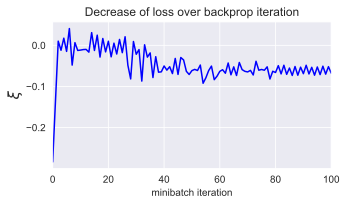

In [71]:
# Plot the loss over the iterations
fig = plt.figure(figsize=(5, 3))
plt.plot(ls_of_loss, 'b-')
plt.xlabel('minibatch iteration')
plt.ylabel('$\\xi$', fontsize=15)
plt.title('Decrease of loss over backprop iteration')
plt.xlim(0, 100)
fig.subplots_adjust(bottom=0.2)
plt.show()
#

## Przykłady testowe
Powyższy rysunek pokazuje, że trening doprowadził do utraty 0. Oczekujemy, że sieć nauczyła się doskonale wykonywać dodawanie binarne dla naszych przykładów szkoleniowych. Jeśli przepuścimy przez sieć kilka niezależnych przypadków testowych i wydrukujemy je, zobaczymy, że sieć również wygeneruje prawidłowe dane wyjściowe dla tych przypadków testowych.

In [72]:
# Create test samples
nb_test = 5
Xtest, Ttest = create_dataset(nb_test, sequence_len)
# Push test data through network
Y = RNN.getBinaryOutput(Xtest)
Yf = RNN.getOutput(Xtest)

# Print out all test examples
for i in range(Xtest.shape[0]):
    printSample(Xtest[i,:,0], Xtest[i,:,1], Ttest[i,:,:], Y[i,:,:])
    print('')
#

x1:   00001010111000001111100101111010   1587480400
x2: - 01000110101110011100011110111100   1038327138
      -------   --
t:  = 01110111100101101101110100000100   549153262
y:  = 01110111100111111101111110000100

x1:   11010101100000110000100010010100   688964011
x2: - 01111111011100010100101100000100   550670078
      -------   --
t:  = 10110101010011000111110000010000   138293933
y:  = 10111111011111000111111100010000

x1:   00010001011000011000001111111010   1606518408
x2: - 01000000011111000110111100000000   16137730
      -------   --
t:  = 01100001000100101101001101111010   1590380678
y:  = 01100001000111101111111101111010

x1:   11001000111010011000110110000010   1102157587
x2: - 01111100100011011011101011010000   190689598
      -------   --
t:  = 10101011101001111100101001101100   911467989
y:  = 10111111101001111111101001111100

x1:   01111011011101010011100000001110   1880927966
x2: - 11010010000110101011010011110010   1328371787
      -------   --
t:  = 1100100101101010111

## Zadania
Opracować rekurencyjną sieć neuronową która implementuje operacje na dwóch liczbach binarnych:
1. Różnica dwóch liczb 16-bitowych
2. Suma dwóch liczb 32-bitowych
3. Różnica dwóch liczb 32-bitowych
4. Suma dwóch liczb 16-bitowych
5. Różnica dwóch liczb 24-bitowych
6. Suma dwóch liczb 24-bitowych
7. Różnica dwóch liczb 18-bitowych
8. Suma dwóch liczb 18-bitowych
9. Różnica dwóch liczb 12-bitowych
10. Suma dwóch liczb 12-bitowych
11. Różnica dwóch liczb 15-bitowych
12. Suma dwóch liczb 15-bitowych
13. Różnica dwóch liczb 28-bitowych
14. Suma dwóch liczb 28-bitowych
15. Różnica dwóch liczb 20-bitowych
16. Suma dwóch liczb 20-bitowych